In [1]:
from luwiji.rnn import illustration

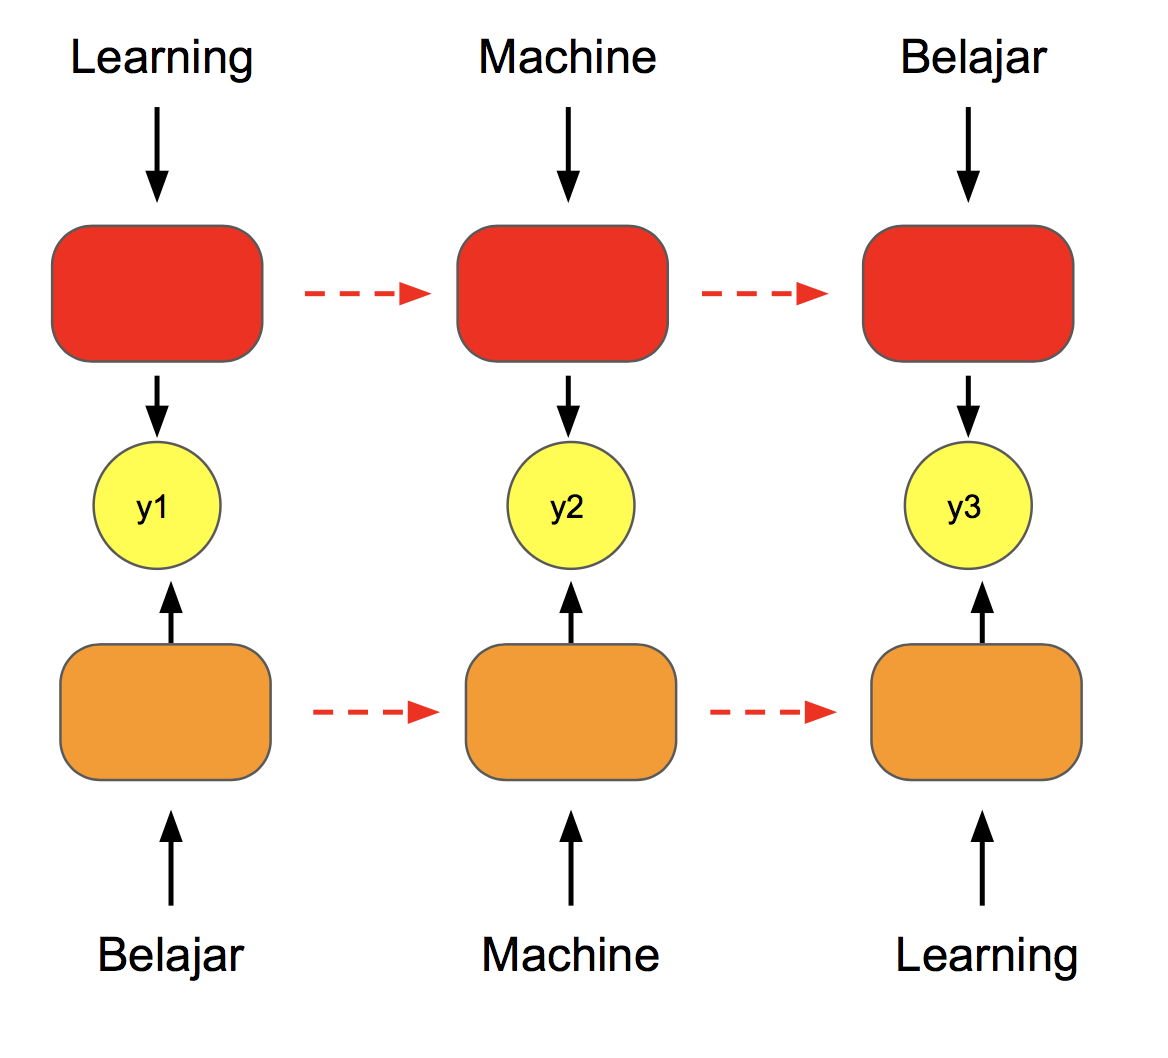

In [2]:
illustration.blstm

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [4]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
df = pd.read_csv("data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


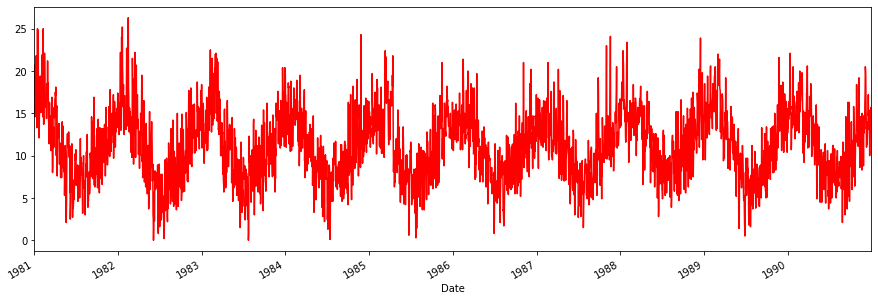

In [6]:
 df.Temp.plot(figsize=(15,5), color="r")

# Dataset Splitting

In [7]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

# Dataset & Dataloader

In [8]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [9]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)


(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



# Arsitektur & Config

In [11]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [22]:
config = set_config({
    "input_size" : train_set.n_feature,
    "seq_len" : train_set.n_seq,
    "output_size" : 1, 
    "hidden_size" : 64, 
    "num_layers"  : 2,
    "dropout"     : 0
})

# Training Preparation -> MCOC

In [26]:
model = BiLSTM(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
callback = Callback(model, config, outdir="model/bilstm")

# Training

In [27]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 136.0258 | Test_cost  = 136.4320 | 




Epoch     2
Train_cost  = 122.5657 | Test_cost  = 120.0586 | 




Epoch     3
Train_cost  = 104.9574 | Test_cost  = 99.2643 | 




Epoch     4
Train_cost  = 84.6171 | Test_cost  = 78.7320 | 




Epoch     5
Train_cost  = 66.0178 | Test_cost  = 61.2538 | 




Epoch     6
Train_cost  = 50.9207 | Test_cost  = 47.8780 | 




Epoch     7
Train_cost  = 39.8772 | Test_cost  = 38.3636 | 




Epoch     8
Train_cost  = 32.2054 | Test_cost  = 31.6970 | 




Epoch     9
Train_cost  = 26.9389 | Test_cost  = 27.0813 | 




Epoch    10
Train_cost  = 23.4022 | Test_cost  = 23.9545 | 




Epoch    11
Train_cost  = 21.0739 | Test_cost  = 21.8461 | 




Epoch    12
Train_cost  = 19.5443 | Test_cost  = 20.3987 | 




Epoch    13
Train_cost  = 18.5315 | Test_cost  = 19.4060 | 




Epoch    14
Train_cost  = 17.8719 | Test_cost  = 18.7320 | 




Epoch    15
Train_cost  = 17.4463 | Test_cost  = 18.2694 | 




Epoch    16
Train_cost  = 17.1697 | Test_cost  = 17.9490 | 




Epoch    17
Train_cost  = 16.9905 | Test_cost  = 17.7258 | 




Epoch    18
Train_cost  = 16.8694 | Test_cost  = 17.5637 | 




Epoch    19
Train_cost  = 16.7827 | Test_cost  = 17.4413 | 




Epoch    20
Train_cost  = 16.7139 | Test_cost  = 17.3442 | 


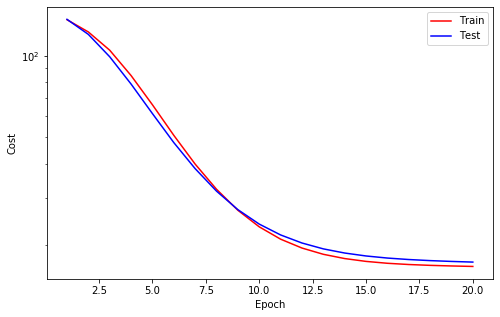



Epoch    21
Train_cost  = 16.6574 | Test_cost  = 17.2666 | 




Epoch    22
Train_cost  = 16.6075 | Test_cost  = 17.1995 | 




Epoch    23
Train_cost  = 16.5584 | Test_cost  = 17.1364 | 




Epoch    24
Train_cost  = 16.5028 | Test_cost  = 17.0694 | 




Epoch    25
Train_cost  = 16.4354 | Test_cost  = 16.9941 | 




Epoch    26
Train_cost  = 16.3494 | Test_cost  = 16.8991 | 




Epoch    27
Train_cost  = 16.2312 | Test_cost  = 16.7769 | 




Epoch    28
Train_cost  = 16.0754 | Test_cost  = 16.6271 | 




Epoch    29
Train_cost  = 15.8755 | Test_cost  = 16.4271 | 




Epoch    30
Train_cost  = 15.5989 | Test_cost  = 16.1309 | 




Epoch    31
Train_cost  = 15.2036 | Test_cost  = 15.7007 | 




Epoch    32
Train_cost  = 14.6761 | Test_cost  = 15.0397 | 




Epoch    33
Train_cost  = 13.7815 | Test_cost  = 13.9311 | 




Epoch    34
Train_cost  = 12.7856 | Test_cost  = 12.7386 | 




Epoch    35
Train_cost  = 11.4973 | Test_cost  = 11.2997 | 




Epoch    36
Train_cost  = 10.3226 | Test_cost  = 10.2232 | 




Epoch    37
Train_cost  = 9.4659 | Test_cost  = 9.3966 | 




Epoch    38
Train_cost  = 8.8002 | Test_cost  = 8.6939 | 




Epoch    39
Train_cost  = 8.2580 | Test_cost  = 8.0991 | 




Epoch    40
Train_cost  = 7.7791 | Test_cost  = 7.5853 | 


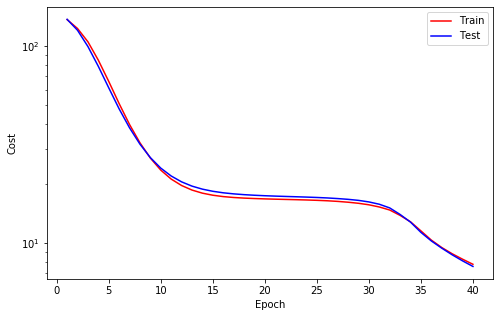



Epoch    41
Train_cost  = 7.3616 | Test_cost  = 7.1514 | 




Epoch    42
Train_cost  = 7.0092 | Test_cost  = 6.7668 | 




Epoch    43
Train_cost  = 6.6936 | Test_cost  = 6.4571 | 




Epoch    44
Train_cost  = 6.4126 | Test_cost  = 6.1487 | 




Epoch    45
Train_cost  = 6.1529 | Test_cost  = 5.8882 | 




Epoch    46
Train_cost  = 5.9169 | Test_cost  = 5.6394 | 




Epoch    47
Train_cost  = 5.6912 | Test_cost  = 5.4101 | 




Epoch    48
Train_cost  = 5.4807 | Test_cost  = 5.1984 | 




Epoch    49
Train_cost  = 5.2864 | Test_cost  = 5.0060 | 




Epoch    50
Train_cost  = 5.1045 | Test_cost  = 4.8136 | 




Epoch    51
Train_cost  = 4.9250 | Test_cost  = 4.6244 | 




Epoch    52
Train_cost  = 4.7536 | Test_cost  = 4.4576 | 




Epoch    53
Train_cost  = 4.5887 | Test_cost  = 4.2818 | 




Epoch    54
Train_cost  = 4.4292 | Test_cost  = 4.1261 | 




Epoch    55
Train_cost  = 4.2809 | Test_cost  = 3.9724 | 




Epoch    56
Train_cost  = 4.1421 | Test_cost  = 3.8176 | 




Epoch    57
Train_cost  = 4.0042 | Test_cost  = 3.6796 | 




Epoch    58
Train_cost  = 3.8799 | Test_cost  = 3.5289 | 




Epoch    59
Train_cost  = 3.7498 | Test_cost  = 3.4073 | 




Epoch    60
Train_cost  = 3.6350 | Test_cost  = 3.2661 | 


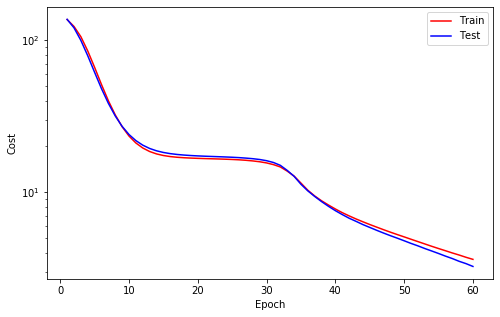



Epoch    61
Train_cost  = 3.5137 | Test_cost  = 3.1472 | 




Epoch    62
Train_cost  = 3.4037 | Test_cost  = 3.0299 | 




Epoch    63
Train_cost  = 3.2980 | Test_cost  = 2.9072 | 




Epoch    64
Train_cost  = 3.1890 | Test_cost  = 2.7963 | 




Epoch    65
Train_cost  = 3.0849 | Test_cost  = 2.6895 | 




Epoch    66
Train_cost  = 2.9838 | Test_cost  = 2.5799 | 




Epoch    67
Train_cost  = 2.8824 | Test_cost  = 2.4735 | 




Epoch    68
Train_cost  = 2.7832 | Test_cost  = 2.3714 | 




Epoch    69
Train_cost  = 2.6880 | Test_cost  = 2.2706 | 




Epoch    70
Train_cost  = 2.5952 | Test_cost  = 2.1722 | 




Epoch    71
Train_cost  = 2.5039 | Test_cost  = 2.0776 | 




Epoch    72
Train_cost  = 2.4150 | Test_cost  = 1.9864 | 




Epoch    73
Train_cost  = 2.3285 | Test_cost  = 1.8975 | 




Epoch    74
Train_cost  = 2.2432 | Test_cost  = 1.8121 | 




Epoch    75
Train_cost  = 2.1595 | Test_cost  = 1.7315 | 




Epoch    76
Train_cost  = 2.0776 | Test_cost  = 1.6532 | 




Epoch    77
Train_cost  = 1.9973 | Test_cost  = 1.5772 | 




Epoch    78
Train_cost  = 1.9186 | Test_cost  = 1.5039 | 




Epoch    79
Train_cost  = 1.8421 | Test_cost  = 1.4335 | 




Epoch    80
Train_cost  = 1.7685 | Test_cost  = 1.3664 | 


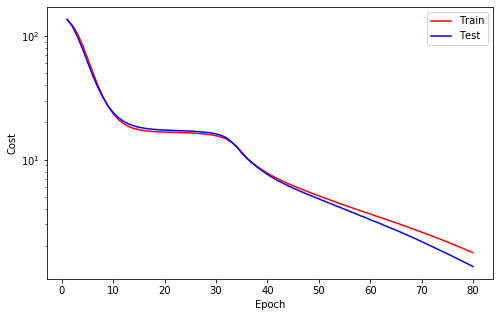



Epoch    81
Train_cost  = 1.6982 | Test_cost  = 1.3028 | 




Epoch    82
Train_cost  = 1.6319 | Test_cost  = 1.2429 | 




Epoch    83
Train_cost  = 1.5697 | Test_cost  = 1.1867 | 




Epoch    84
Train_cost  = 1.5122 | Test_cost  = 1.1342 | 




Epoch    85
Train_cost  = 1.4593 | Test_cost  = 1.0858 | 




Epoch    86
Train_cost  = 1.4110 | Test_cost  = 1.0412 | 




Epoch    87
Train_cost  = 1.3668 | Test_cost  = 1.0002 | 




Epoch    88
Train_cost  = 1.3266 | Test_cost  = 0.9628 | 




Epoch    89
Train_cost  = 1.2899 | Test_cost  = 0.9285 | 




Epoch    90
Train_cost  = 1.2566 | Test_cost  = 0.8970 | 




Epoch    91
Train_cost  = 1.2260 | Test_cost  = 0.8680 | 




Epoch    92
Train_cost  = 1.1978 | Test_cost  = 0.8411 | 




Epoch    93
Train_cost  = 1.1716 | Test_cost  = 0.8161 | 




Epoch    94
Train_cost  = 1.1471 | Test_cost  = 0.7927 | 




Epoch    95
Train_cost  = 1.1240 | Test_cost  = 0.7706 | 




Epoch    96
Train_cost  = 1.1022 | Test_cost  = 0.7498 | 




Epoch    97
Train_cost  = 1.0814 | Test_cost  = 0.7301 | 




Epoch    98
Train_cost  = 1.0615 | Test_cost  = 0.7115 | 




Epoch    99
Train_cost  = 1.0425 | Test_cost  = 0.6937 | 




Epoch   100
Train_cost  = 1.0243 | Test_cost  = 0.6768 | 


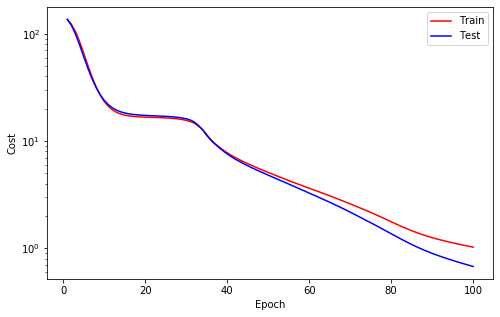



Epoch   101
Train_cost  = 1.0068 | Test_cost  = 0.6607 | 




Epoch   102
Train_cost  = 0.9899 | Test_cost  = 0.6454 | 




Epoch   103
Train_cost  = 0.9737 | Test_cost  = 0.6308 | 




Epoch   104
Train_cost  = 0.9580 | Test_cost  = 0.6168 | 




Epoch   105
Train_cost  = 0.9429 | Test_cost  = 0.6034 | 




Epoch   106
Train_cost  = 0.9283 | Test_cost  = 0.5906 | 




Epoch   107
Train_cost  = 0.9143 | Test_cost  = 0.5784 | 




Epoch   108
Train_cost  = 0.9008 | Test_cost  = 0.5669 | 




Epoch   109
Train_cost  = 0.8877 | Test_cost  = 0.5558 | 




Epoch   110
Train_cost  = 0.8751 | Test_cost  = 0.5454 | 




Epoch   111
Train_cost  = 0.8630 | Test_cost  = 0.5354 | 




Epoch   112
Train_cost  = 0.8512 | Test_cost  = 0.5259 | 




Epoch   113
Train_cost  = 0.8398 | Test_cost  = 0.5168 | 




Epoch   114
Train_cost  = 0.8288 | Test_cost  = 0.5082 | 




Epoch   115
Train_cost  = 0.8182 | Test_cost  = 0.5000 | 




Epoch   116
Train_cost  = 0.8079 | Test_cost  = 0.4922 | 




Epoch   117
Train_cost  = 0.7980 | Test_cost  = 0.4847 | 




Epoch   118
Train_cost  = 0.7884 | Test_cost  = 0.4776 | 




Epoch   119
Train_cost  = 0.7791 | Test_cost  = 0.4708 | 




Epoch   120
Train_cost  = 0.7701 | Test_cost  = 0.4643 | 


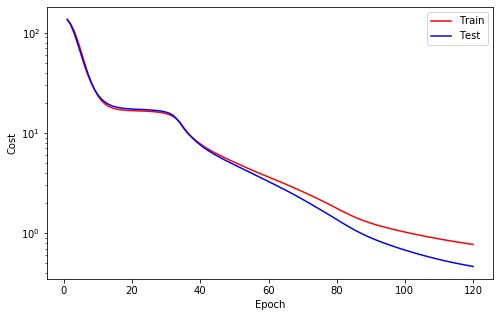



Epoch   121
Train_cost  = 0.7614 | Test_cost  = 0.4581 | 




Epoch   122
Train_cost  = 0.7529 | Test_cost  = 0.4521 | 




Epoch   123
Train_cost  = 0.7448 | Test_cost  = 0.4464 | 




Epoch   124
Train_cost  = 0.7369 | Test_cost  = 0.4410 | 




Epoch   125
Train_cost  = 0.7292 | Test_cost  = 0.4357 | 




Epoch   126
Train_cost  = 0.7218 | Test_cost  = 0.4307 | 




Epoch   127
Train_cost  = 0.7146 | Test_cost  = 0.4259 | 




Epoch   128
Train_cost  = 0.7076 | Test_cost  = 0.4212 | 




Epoch   129
Train_cost  = 0.7007 | Test_cost  = 0.4167 | 




Epoch   130
Train_cost  = 0.6941 | Test_cost  = 0.4124 | 




Epoch   131
Train_cost  = 0.6876 | Test_cost  = 0.4083 | 




Epoch   132
Train_cost  = 0.6813 | Test_cost  = 0.4043 | 




Epoch   133
Train_cost  = 0.6753 | Test_cost  = 0.4005 | 




Epoch   134
Train_cost  = 0.6693 | Test_cost  = 0.3968 | 




Epoch   135
Train_cost  = 0.6635 | Test_cost  = 0.3933 | 




Epoch   136
Train_cost  = 0.6579 | Test_cost  = 0.3898 | 




Epoch   137
Train_cost  = 0.6524 | Test_cost  = 0.3865 | 




Epoch   138
Train_cost  = 0.6471 | Test_cost  = 0.3834 | 




Epoch   139
Train_cost  = 0.6419 | Test_cost  = 0.3803 | 




Epoch   140
Train_cost  = 0.6368 | Test_cost  = 0.3774 | 


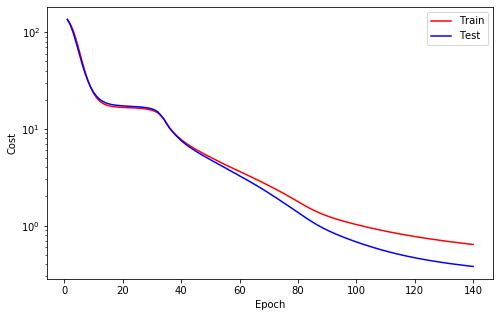



Epoch   141
Train_cost  = 0.6319 | Test_cost  = 0.3746 | 




Epoch   142
Train_cost  = 0.6270 | Test_cost  = 0.3719 | 




Epoch   143
Train_cost  = 0.6223 | Test_cost  = 0.3693 | 




Epoch   144
Train_cost  = 0.6177 | Test_cost  = 0.3668 | 




Epoch   145
Train_cost  = 0.6132 | Test_cost  = 0.3644 | 




Epoch   146
Train_cost  = 0.6088 | Test_cost  = 0.3620 | 




Epoch   147
Train_cost  = 0.6045 | Test_cost  = 0.3598 | 




Epoch   148
Train_cost  = 0.6003 | Test_cost  = 0.3576 | 




Epoch   149
Train_cost  = 0.5962 | Test_cost  = 0.3556 | 




Epoch   150
Train_cost  = 0.5921 | Test_cost  = 0.3536 | 




Epoch   151
Train_cost  = 0.5882 | Test_cost  = 0.3517 | 




Epoch   152
Train_cost  = 0.5844 | Test_cost  = 0.3498 | 




Epoch   153
Train_cost  = 0.5806 | Test_cost  = 0.3480 | 




Epoch   154
Train_cost  = 0.5769 | Test_cost  = 0.3463 | 




Epoch   155
Train_cost  = 0.5733 | Test_cost  = 0.3446 | 




Epoch   156
Train_cost  = 0.5698 | Test_cost  = 0.3430 | 




Epoch   157
Train_cost  = 0.5663 | Test_cost  = 0.3414 | 




Epoch   158
Train_cost  = 0.5630 | Test_cost  = 0.3399 | 




Epoch   159
Train_cost  = 0.5597 | Test_cost  = 0.3384 | 




Epoch   160
Train_cost  = 0.5564 | Test_cost  = 0.3370 | 


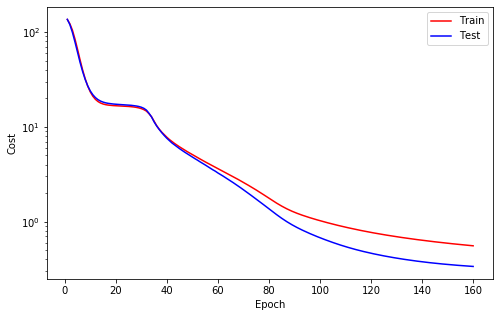



Epoch   161
Train_cost  = 0.5532 | Test_cost  = 0.3356 | 




Epoch   162
Train_cost  = 0.5500 | Test_cost  = 0.3342 | 




Epoch   163
Train_cost  = 0.5470 | Test_cost  = 0.3330 | 




Epoch   164
Train_cost  = 0.5440 | Test_cost  = 0.3317 | 




Epoch   165
Train_cost  = 0.5410 | Test_cost  = 0.3304 | 




Epoch   166
Train_cost  = 0.5381 | Test_cost  = 0.3292 | 




Epoch   167
Train_cost  = 0.5353 | Test_cost  = 0.3281 | 




Epoch   168
Train_cost  = 0.5325 | Test_cost  = 0.3270 | 




Epoch   169
Train_cost  = 0.5298 | Test_cost  = 0.3259 | 




Epoch   170
Train_cost  = 0.5271 | Test_cost  = 0.3248 | 




Epoch   171
Train_cost  = 0.5244 | Test_cost  = 0.3238 | 




Epoch   172
Train_cost  = 0.5218 | Test_cost  = 0.3228 | 




Epoch   173
Train_cost  = 0.5193 | Test_cost  = 0.3218 | 




Epoch   174
Train_cost  = 0.5168 | Test_cost  = 0.3209 | 




Epoch   175
Train_cost  = 0.5143 | Test_cost  = 0.3199 | 




Epoch   176
Train_cost  = 0.5119 | Test_cost  = 0.3190 | 




Epoch   177
Train_cost  = 0.5095 | Test_cost  = 0.3182 | 




Epoch   178
Train_cost  = 0.5071 | Test_cost  = 0.3173 | 




Epoch   179
Train_cost  = 0.5048 | Test_cost  = 0.3165 | 




Epoch   180
Train_cost  = 0.5025 | Test_cost  = 0.3157 | 


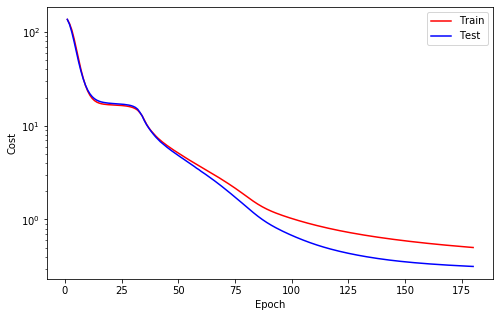



Epoch   181
Train_cost  = 0.5003 | Test_cost  = 0.3149 | 




Epoch   182
Train_cost  = 0.4981 | Test_cost  = 0.3141 | 




Epoch   183
Train_cost  = 0.4960 | Test_cost  = 0.3133 | 




Epoch   184
Train_cost  = 0.4938 | Test_cost  = 0.3126 | 




Epoch   185
Train_cost  = 0.4917 | Test_cost  = 0.3119 | 




Epoch   186
Train_cost  = 0.4896 | Test_cost  = 0.3112 | 




Epoch   187
Train_cost  = 0.4876 | Test_cost  = 0.3105 | 




Epoch   188
Train_cost  = 0.4856 | Test_cost  = 0.3098 | 




Epoch   189
Train_cost  = 0.4836 | Test_cost  = 0.3091 | 




Epoch   190
Train_cost  = 0.4816 | Test_cost  = 0.3085 | 




Epoch   191
Train_cost  = 0.4797 | Test_cost  = 0.3079 | 




Epoch   192
Train_cost  = 0.4777 | Test_cost  = 0.3072 | 




Epoch   193
Train_cost  = 0.4758 | Test_cost  = 0.3066 | 




Epoch   194
Train_cost  = 0.4740 | Test_cost  = 0.3061 | 




Epoch   195
Train_cost  = 0.4721 | Test_cost  = 0.3055 | 




Epoch   196
Train_cost  = 0.4703 | Test_cost  = 0.3049 | 




Epoch   197
Train_cost  = 0.4685 | Test_cost  = 0.3044 | 




Epoch   198
Train_cost  = 0.4667 | Test_cost  = 0.3038 | 




Epoch   199
Train_cost  = 0.4649 | Test_cost  = 0.3033 | 




Epoch   200
Train_cost  = 0.4632 | Test_cost  = 0.3029 | 


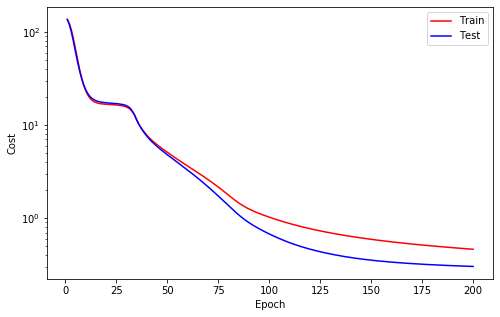



Epoch   201
Train_cost  = 0.4615 | Test_cost  = 0.3024 | 




Epoch   202
Train_cost  = 0.4597 | Test_cost  = 0.3019 | 




Epoch   203
Train_cost  = 0.4581 | Test_cost  = 0.3015 | 




Epoch   204
Train_cost  = 0.4564 | Test_cost  = 0.3011 | 




Epoch   205
Train_cost  = 0.4547 | Test_cost  = 0.3007 | 




Epoch   206
Train_cost  = 0.4531 | Test_cost  = 0.3004 | 




Epoch   207
Train_cost  = 0.4515 | Test_cost  = 0.3001 | 




Epoch   208
Train_cost  = 0.4499 | Test_cost  = 0.2997 | 




Epoch   209
Train_cost  = 0.4483 | Test_cost  = 0.2994 | 




Epoch   210
Train_cost  = 0.4468 | Test_cost  = 0.2992 | 




Epoch   211
Train_cost  = 0.4453 | Test_cost  = 0.2989 | 




Epoch   212
Train_cost  = 0.4438 | Test_cost  = 0.2987 | 




Epoch   213
Train_cost  = 0.4423 | Test_cost  = 0.2984 | 




Epoch   214
Train_cost  = 0.4408 | Test_cost  = 0.2982 | 




Epoch   215
Train_cost  = 0.4393 | Test_cost  = 0.2980 | 




Epoch   216
Train_cost  = 0.4379 | Test_cost  = 0.2978 | 




Epoch   217
Train_cost  = 0.4364 | Test_cost  = 0.2977 | 




Epoch   218
Train_cost  = 0.4350 | Test_cost  = 0.2975 | 




Epoch   219
Train_cost  = 0.4336 | Test_cost  = 0.2974 | 




Epoch   220
Train_cost  = 0.4323 | Test_cost  = 0.2972 | 


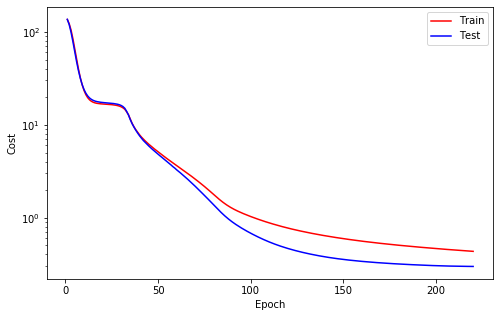



Epoch   221
Train_cost  = 0.4309 | Test_cost  = 0.2971 | 




Epoch   222
Train_cost  = 0.4296 | Test_cost  = 0.2970 | 




Epoch   223
Train_cost  = 0.4282 | Test_cost  = 0.2969 | 




Epoch   224
Train_cost  = 0.4269 | Test_cost  = 0.2968 | 




Epoch   225
Train_cost  = 0.4256 | Test_cost  = 0.2967 | 




Epoch   226
Train_cost  = 0.4243 | Test_cost  = 0.2966 | 




Epoch   227
Train_cost  = 0.4230 | Test_cost  = 0.2965 | 




Epoch   228
Train_cost  = 0.4218 | Test_cost  = 0.2965 | 




Epoch   229
Train_cost  = 0.4205 | Test_cost  = 0.2964 | 




Epoch   230
Train_cost  = 0.4193 | Test_cost  = 0.2963 | 




Epoch   231
Train_cost  = 0.4180 | Test_cost  = 0.2963 | 




Epoch   232
Train_cost  = 0.4168 | Test_cost  = 0.2963 | 




Epoch   233
Train_cost  = 0.4156 | Test_cost  = 0.2962 | 




Epoch   234
Train_cost  = 0.4144 | Test_cost  = 0.2962 | 




Epoch   235
Train_cost  = 0.4132 | Test_cost  = 0.2962 | 




Epoch   236
Train_cost  = 0.4120 | Test_cost  = 0.2962 | 




Epoch   237
Train_cost  = 0.4108 | Test_cost  = 0.2962 | 




Epoch   238
Train_cost  = 0.4097 | Test_cost  = 0.2961 | 




Epoch   239
Train_cost  = 0.4085 | Test_cost  = 0.2961 | 




Epoch   240
Train_cost  = 0.4074 | Test_cost  = 0.2961 | 


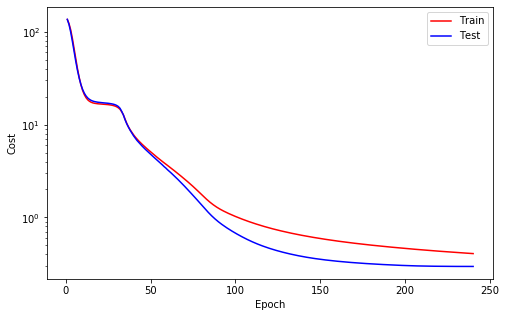

==> EarlyStop patience =  1 | Best test_cost: 0.2961




Epoch   241
Train_cost  = 0.4063 | Test_cost  = 0.2961 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2961




Epoch   242
Train_cost  = 0.4051 | Test_cost  = 0.2962 | 
==> EarlyStop patience =  3 | Best test_cost: 0.2961




Epoch   243
Train_cost  = 0.4040 | Test_cost  = 0.2962 | 
==> EarlyStop patience =  4 | Best test_cost: 0.2961




Epoch   244
Train_cost  = 0.4029 | Test_cost  = 0.2962 | 
==> EarlyStop patience =  5 | Best test_cost: 0.2961
==> Execute Early Stopping at epoch: 244 | Best test_cost: 0.2961
==> Best model is saved at model/bilstm


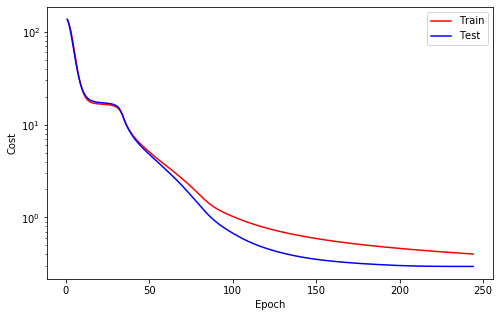

In [28]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Sanity Check

In [29]:
from luwiji.rnn import illustration

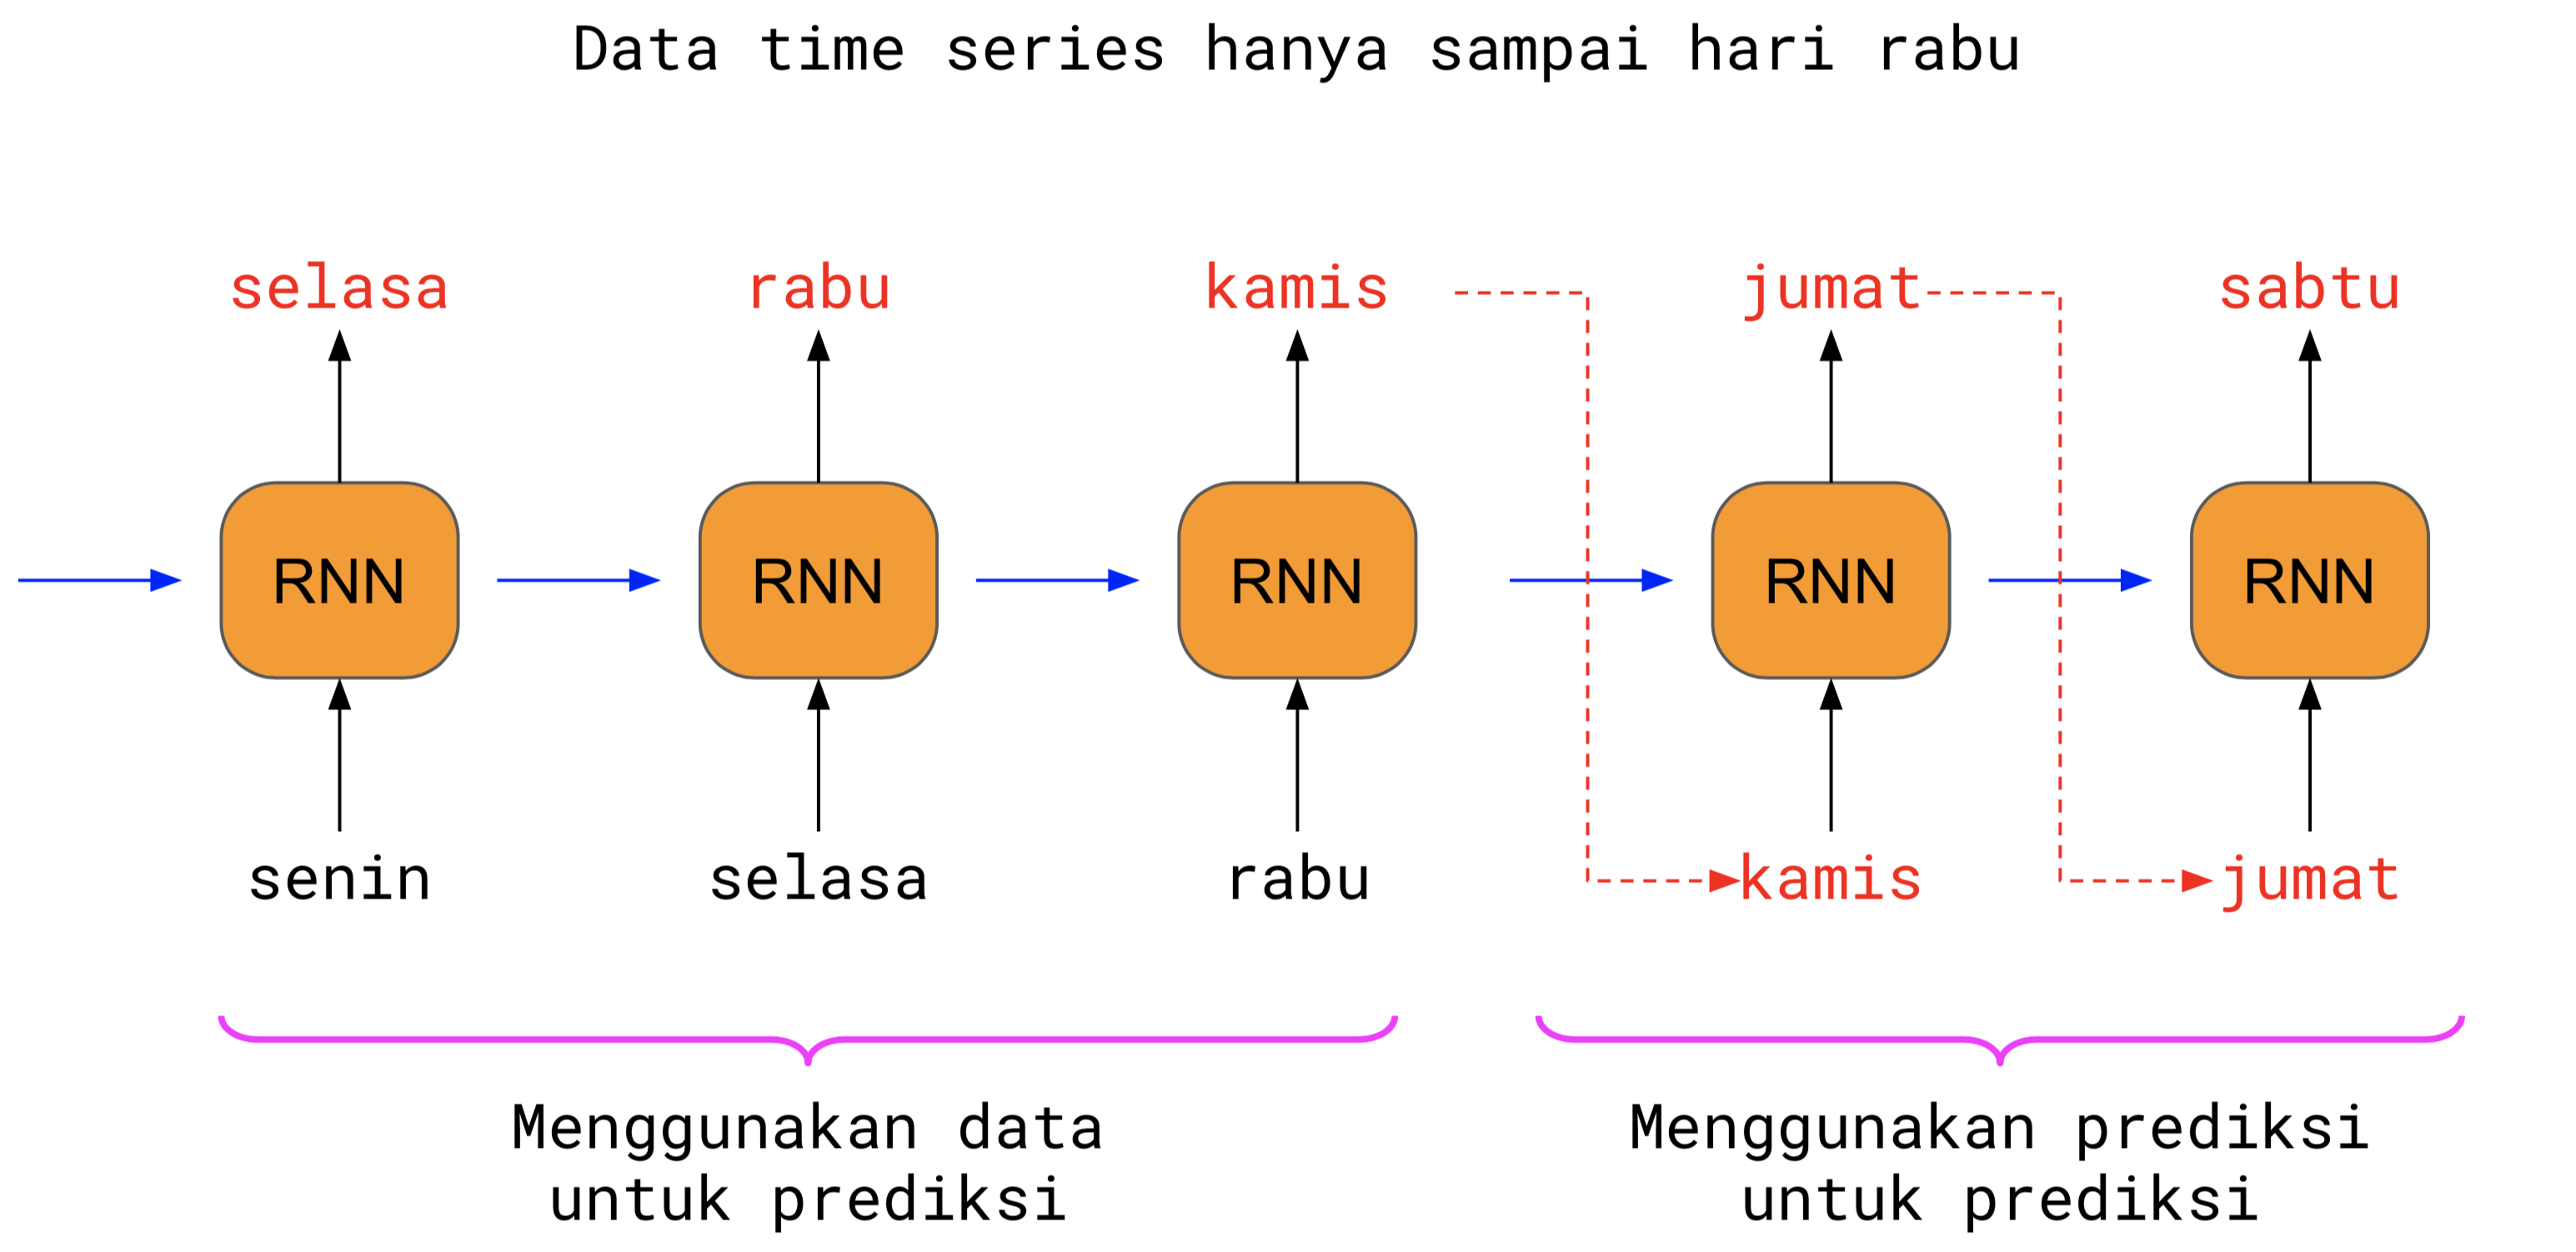

In [30]:
illustration.forecast

In [31]:
from utils import data4pred, pred4pred

In [32]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

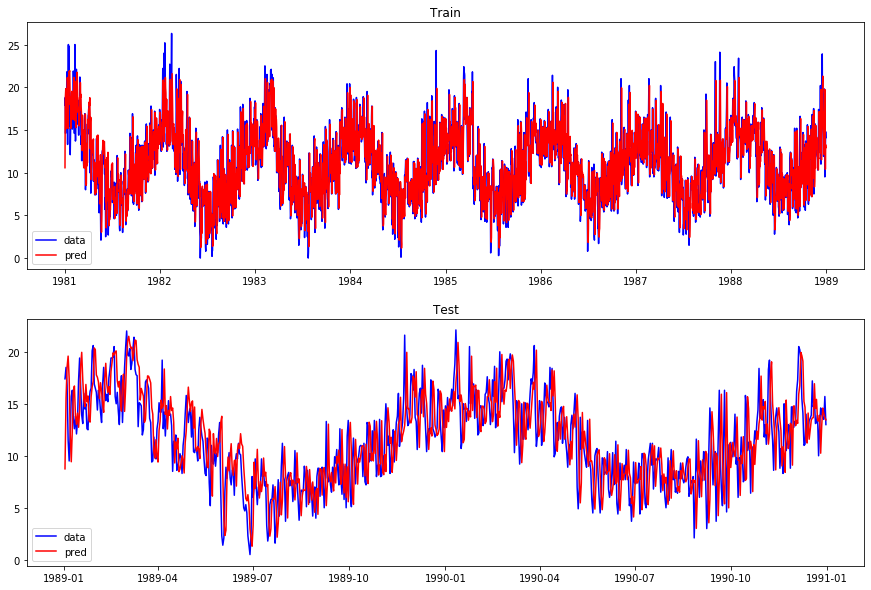

In [33]:
# Data 4 Pred
plt.figure(figsize=(15,10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'test')

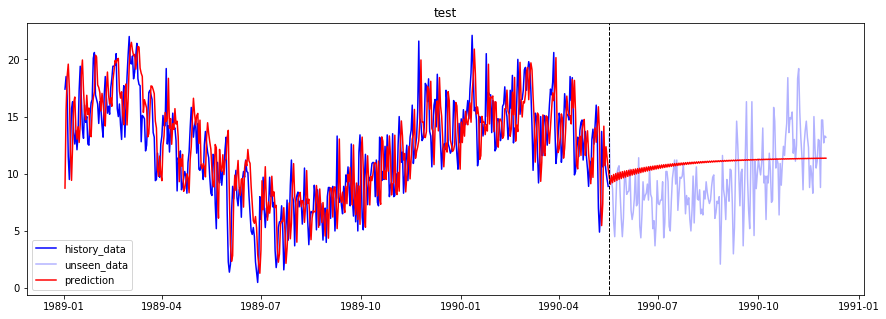

In [34]:
# Pred 4 Pred
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test")